In [1]:
import numpy as np
import pandas as pd
import time
import os

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.linalg import Vectors

from matplotlib import pyplot as plt

from pyspark.sql import SparkSession
# from pyspark.ml.clustering import KMeans, KMeansModel

import networkx as nx   # thư viện để tạo, thao tác, học cấu trúc.... của các mạng phức tạp
import seaborn as sns  # thư viện để trực quan hóa dữ liệu

sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

float_formatter = lambda x: "%.6f" % x

np.set_printoptions(formatter={'float_kind':float_formatter})


In [32]:
def draw_graph(G):
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=10)
    # nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_edges(G, pos, width=0.1, alpha=0.5)


def draw_graph_cluster(G, labels):
    pos = nx.spring_layout(G)
    nx.draw(
        G,
        pos,
        node_color=node_colors,
        node_size=10,
        width=0.1,
        alpha=0.5,
        with_labels=False,
    )

def get_node_color(label):
    switcher = {
        0: 'red',
        1: 'blue',
        2: 'orange',
        3: 'gray',
        4: 'violet',
        5: 'pink',
        6: 'purple',
        7: 'brown',
        8: 'yellow',
        9: 'lime',
        10: 'cyan'
    }
    return switcher.get(label, 'Invalid label')

In [2]:
spark = SparkSession.builder \
    .master("local") \
    .appName("CLustering") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()
spark

In [3]:
base_path = os.getcwd()
# file_input = base_path + "/facebook_combined.txt" 
file_input = base_path + "/ChG-Miner_miner-chem-gene.tsv"
file_input

'/home/dat/Documents/graph-clustering/ChG-Miner_miner-chem-gene.tsv'

In [4]:
pdf = pd.read_table(file_input, sep='\t', names=['src', 'dst'])
pdf.head()

,src,dst
0,DB00357,P05108
1,DB02721,P00325
2,DB00773,P23219
3,DB07138,Q16539
4,DB08136,P24941


In [5]:
pdf = pdf.to_numpy()

In [6]:
G = nx.Graph()
G.add_edges_from(pdf)

In [7]:
len(G.nodes())

7343

In [8]:
len(G.edges())

15139

In [9]:
# adjacency matrix
W = nx.adjacency_matrix(G)
print(W.todense())

[[0 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [10]:
# degree matrix
D = np.diag(np.sum(np.array(W.todense()), axis=1))
print(D)

[[ 5  0  0 ...  0  0  0]
 [ 0 15  0 ...  0  0  0]
 [ 0  0  3 ...  0  0  0]
 ...
 [ 0  0  0 ...  1  0  0]
 [ 0  0  0 ...  0  1  0]
 [ 0  0  0 ...  0  0  1]]


In [11]:
# Laplacian matrix
L = D - W
print(L)

[[ 5 -1  0 ...  0  0  0]
 [-1 15  0 ...  0  0  0]
 [ 0  0  3 ...  0  0  0]
 ...
 [ 0  0  0 ...  1  0  0]
 [ 0  0  0 ...  0  1  0]
 [ 0  0  0 ...  0  0  1]]


In [12]:
# eigenvalues, eigenvector
eigenvals, eigenvcts = np.linalg.eigh(L)

In [13]:
eigenvcts

matrix([[-0.012290, 0.000000, 0.000000, ..., -0.000087, 0.000026,
         -0.001726],
        [-0.012290, -0.000000, -0.000000, ..., 0.000108, -0.000086,
         0.000037],
        [-0.012290, -0.000000, -0.000000, ..., -0.000000, 0.000000,
         -0.000000],
        ...,
        [0.000000, 0.000000, 0.000000, ..., 0.000000, 0.000000, 0.000000],
        [-0.012290, -0.000000, 0.000000, ..., 0.000000, -0.000000,
         0.000000],
        [-0.012290, 0.000000, -0.000000, ..., -0.000000, 0.000000,
         -0.000000]])

In [14]:
eigenvals

array([-0.000000, -0.000000, -0.000000, ..., 289.046357, 323.042557,
       585.016763])

In [15]:
eigenvals_sorted_indices = np.argsort(eigenvals)
eigenvals_sorted = eigenvals[eigenvals_sorted_indices]

In [16]:
eigenvals_sorted_indices

array([   0,    1,    2, ..., 7340, 7341, 7342])

In [17]:
eigenvals_sorted

array([-0.000000, -0.000000, -0.000000, ..., 289.046357, 323.042557,
       585.016763])

[Text(0, 0.5, '$\\lambda$'),
 Text(0.5, 0, 'index'),
 Text(0.5, 1.0, 'Sorted Eigenvalues Graph Laplacian')]

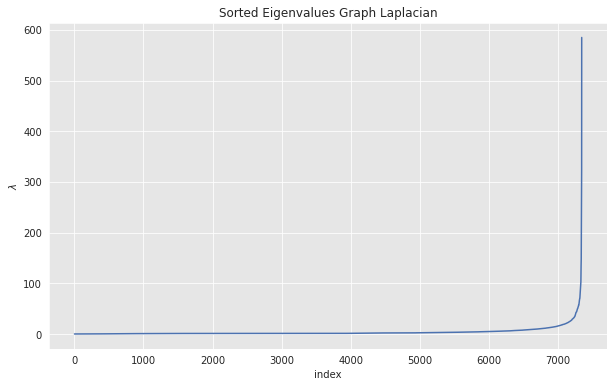

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=range(1, eigenvals_sorted_indices.size + 1), y=eigenvals_sorted, ax=ax)
ax.set(title='Sorted Eigenvalues Graph Laplacian', xlabel='index', ylabel=r'$\lambda$')

[Text(0, 0.5, '$\\lambda$'),
 Text(0.5, 0, 'index'),
 Text(0.5, 1.0, 'Sorted Eigenvalues Graph Laplacian (First 250)')]

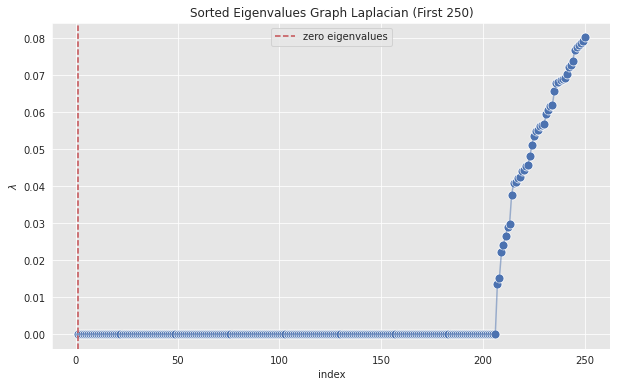

In [19]:
index_lim = 250

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=range(1, eigenvals_sorted_indices[: index_lim].size + 1), y=eigenvals_sorted[: index_lim], s=80, ax=ax)
sns.lineplot(x=range(1, eigenvals_sorted_indices[: index_lim].size + 1), y=eigenvals_sorted[: index_lim], alpha=0.5, ax=ax)
ax.axvline(x=1, color=sns_c[3], label='zero eigenvalues', linestyle='--')
ax.legend()
ax.set(title=f'Sorted Eigenvalues Graph Laplacian (First {index_lim})', xlabel='index', ylabel=r'$\lambda$')

In [20]:
zero_eigenvals_index = np.argwhere(abs(eigenvals) < 0.02)
zero_eigenvals_index.squeeze()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [27]:
proj_df = pd.DataFrame(eigenvcts[:, zero_eigenvals_index.squeeze()[206]])
# proj_df = proj_df.transpose()
proj_df = proj_df.rename(columns={0: 'features'})
proj_df

,features
0,0.000697
1,0.000696
2,0.000638
3,0.000632
4,0.000659
...,...
7338,0.000503
7339,0.000714
7340,0.000000
7341,0.000747


In [28]:
U = []
for x in proj_df['features']:
    U.append(Vectors.dense(x))
pdf_train = pd.DataFrame(U, columns=['features'])
df = spark.createDataFrame(pdf_train)
display(df)

DataFrame[features: vector]

In [29]:
# train k-means model
cost = np.zeros(15)
for i in range(2,15):
    kmeans = KMeans(k=i, seed=1)
    model = kmeans.fit(df)
    cost[i] = model.computeCost(df) # requires Spark 2.0 or later

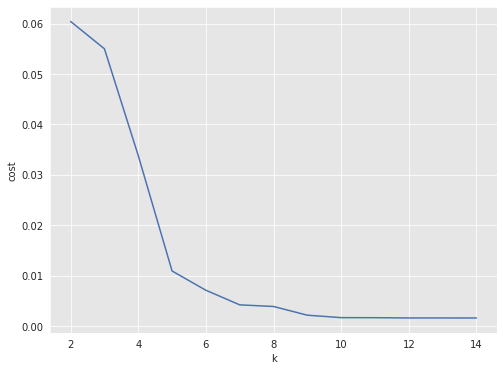

In [30]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,15),cost[2:15])
ax.set_xlabel('k')
ax.set_ylabel('cost')
plt.show()

In [33]:
# train
kmeans = KMeans(k=9, seed=1)
model = kmeans.fit(df)

# Make predictions
predictions = model.transform(df)
rows = predictions.select("features","prediction").collect()

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
silhouette

0.9868031954854416

In [36]:
rows

Row(features=DenseVector([0.0007]), prediction=0),
 Row(features=DenseVector([0.0007]), prediction=0),
 Row(features=DenseVector([0.0007]), prediction=0),
 Row(features=DenseVector([0.0007]), prediction=0),
 Row(features=DenseVector([0.0006]), prediction=0),
 Row(features=DenseVector([0.0007]), prediction=0),
 Row(features=DenseVector([0.0002]), prediction=0),
 Row(features=DenseVector([0.0007]), prediction=0),
 Row(features=DenseVector([0.0007]), prediction=0),
 Row(features=DenseVector([0.0]), prediction=0),
 Row(features=DenseVector([0.0]), prediction=0),
 Row(features=DenseVector([0.0007]), prediction=0),
 Row(features=DenseVector([0.0007]), prediction=0),
 Row(features=DenseVector([0.0007]), prediction=0),
 Row(features=DenseVector([0.0025]), prediction=0),
 Row(features=DenseVector([0.0025]), prediction=0),
 Row(features=DenseVector([0.0007]), prediction=0),
 Row(features=DenseVector([0.0007]), prediction=0),
 Row(features=DenseVector([0.0007]), prediction=0),
 Row(features=Dense

In [34]:
node_colors = []
for label in rows:
    node_colors.append(get_node_color(label.prediction))